# Assignment_2_BDF_V5

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def warn(*args, **kwargs):
    pass
import warnings 
warnings.warn = warn
warnings.filterwarnings("ignore")

In [2]:
#loading the data
returns = pd.read_excel('Retuns_Clean_Small.xlsx')
flows = pd.read_excel('Flows_Clean_Small.xlsx')

# Generating X_full

In [3]:
def generate_X(returns_df, flows_df, stock_id, lag_selected_stock, lag_other_stocks):
    
    #1) X_small (Selected Stock)
    #i) Generate Headers 
    X_small_headers = [str(stock_id) + 'r_t']
    for lag in range(1,lag_selected_stock+1):
        X_small_headers.append(str(stock_id) + 'r_t-' + str(lag))
    for lag in range(1, lag_selected_stock+1):
        X_small_headers.append(str(stock_id) + 'f_t-' + str(lag))
    
    
    X_small = pd.DataFrame(columns = X_small_headers)

    for t in range(len(flows_df)-lag_selected_stock):
        return_flow_stock = [returns_df[stock_id][t+lag_selected_stock]]
        for lag in range(lag_selected_stock-1,-1,-1):
            return_flow_stock.append(returns_df[stock_id][t+lag])
        for lag in range(lag_selected_stock-1,-1,-1):
            return_flow_stock.append(flows_df[stock_id][t+lag])
        X_small.loc[t] = return_flow_stock
            

    
    #2) create list of columns names based on all stocks which had not been picked before
    other_stock_names = list(returns_df.iloc[:,1:].columns)
    other_stock_names.remove(stock_id)


    #3) create dataframe with column names for each stock return and flow for given w window lag
    column_headers = []
    for stock in other_stock_names:
        for lag in range(1,lag_other_stocks+1):
            column_headers.append(str(stock) + 'r_t-' + str(lag))
        for lag in range(1, lag_other_stocks+1):
            column_headers.append(str(stock) + 'f_t-' + str(lag))
            
    
    #4) create single-period lagged returns and flows for each other stock
    X_full_a = pd.DataFrame(columns = column_headers)
    for t in range(len(flows_df)-lag_selected_stock):
        return_flow_row = []
        for stock_id in other_stock_names:
            for lag in range(lag_other_stocks-1,-1,-1):
                return_flow_row.append(returns_df[stock_id][t+(lag)])
            for lag in range(lag_other_stocks-1,-1,-1):
                return_flow_row.append(flows_df[stock_id][t+(lag)])

        X_full_a.loc[t] = return_flow_row
    
    X_full =  pd.concat([X_small, X_full_a], axis=1, sort=False)
    
    return X_full

In [4]:
def generate_X_centroid(returns_df, flows_df, stock_id, lag_selected_stock, lag_other_stocks):
    
    #1) X_small (Selected Stock)
    #i) Generate Headers 
    X_small_headers = [str(stock_id) + 'r_t']
    for lag in range(1,lag_selected_stock+1):
        X_small_headers.append(str(stock_id) + 'r_t-' + str(lag))
    for lag in range(1, lag_selected_stock+1):
        X_small_headers.append(str(stock_id) + 'f_t-' + str(lag))
    
    
    X_small = pd.DataFrame(columns = X_small_headers)

    for t in range(len(flows_df)-lag_selected_stock):
        return_flow_stock = [returns_df[stock_id][t+lag_selected_stock]]
        for lag in range(lag_selected_stock-1,-1,-1):
            return_flow_stock.append(returns_df[stock_id][t+lag])
        for lag in range(lag_selected_stock-1,-1,-1):
            return_flow_stock.append(flows_df[stock_id][t+lag])
        X_small.loc[t] = return_flow_stock
            

    
    #2) create list of columns names based on all stocks which had not been picked before
    other_stock_names = list(returns_df.iloc[:,:].columns)
    other_stock_names.remove(stock_id)


    #3) create dataframe with column names for each stock return and flow for given w window lag
    column_headers = []
    for stock in other_stock_names:
        for lag in range(1,lag_other_stocks+1):
            column_headers.append(str(stock) + 'r_t-' + str(lag))
        for lag in range(1, lag_other_stocks+1):
            column_headers.append(str(stock) + 'f_t-' + str(lag))
            
    
    #4) create single-period lagged returns and flows for each other stock
    X_full_a = pd.DataFrame(columns = column_headers)
    for t in range(len(flows_df)-lag_selected_stock):
        return_flow_row = []
        for stock_id in other_stock_names:
            for lag in range(lag_other_stocks-1,-1,-1):
                return_flow_row.append(returns_df[stock_id][t+(lag)])
            for lag in range(lag_other_stocks-1,-1,-1):
                return_flow_row.append(flows_df[stock_id][t+(lag)])

        X_full_a.loc[t] = return_flow_row
    
    X_full =  pd.concat([X_small, X_full_a], axis=1, sort=False)
    
    return X_full

# Train and test splits

### Train

In [5]:
returns_train = returns.iloc[:int(0.7*len(returns)), :].reset_index(drop=True)
flows_train = flows.iloc[:int(0.7*len(flows)), :].reset_index(drop=True)

### Test

In [6]:
returns_test = returns.iloc[int(0.7*len(returns)):, :].reset_index(drop=True)
flows_test = flows.iloc[int(0.7*len(flows)):, :].reset_index(drop=True)

## Clustering based on correlation

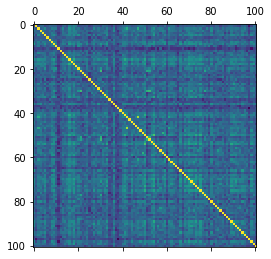

In [59]:
#visualise the correlation matrix based on the last 200 days (in training)

import matplotlib.pyplot as plt

correlation = returns.iloc[len(returns_train)-200:len(returns_train), 1:].corr()
correlation.head()

plt.matshow(correlation)
plt.show()

### Finding the optimal k

In [335]:
#loop over k
SSD_corr = []

K = range(2,16)
for k in K:
    km = KMeans(n_clusters=k, random_state = 5)
    km = km.fit(correlation)
    SSD_corr.append(km.inertia_) #for elbow chart

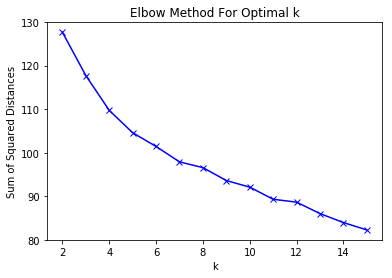

In [336]:
#Elbow chart k = 8
plt.plot(K, SSD_corr, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [81]:
#k-means into 8 clusters
kmeans = KMeans(n_clusters=8,random_state=5).fit(correlation)

#create the output matrix
df = pd.DataFrame(returns_train.values.T[1:])
df['Stock'] = list(returns.columns[1:])
df = df.set_index(df['Stock'])
df = df.drop(columns='Stock')

#predict the clusters
df['Cluster'] = kmeans.predict(correlation)

#computing the centroid
returns_2 = df.groupby(['Cluster']).mean().T

#rename columns 0, generates error
returns_2 = returns_2.rename(columns={0: 11})
returns_2.head()

Cluster,11,1,2,3,4,5,6,7
0,0.003523,0.002759,-0.003271,0.000606,-0.006075,-0.000968,0.002093,-0.007061
1,-0.019302,-0.008399,-0.007256,-0.021691,-0.019733,-0.001984,-0.022964,-0.024524
2,0.009858,-0.001274,-0.025900,0.019346,0.005834,0.001962,-0.005616,0.002425
3,-0.007751,-0.002454,-0.000439,-0.015085,-0.009926,0.003665,-0.002821,0.000929
4,-0.007383,-0.001430,-0.011097,0.000816,0.013154,0.004196,-0.001934,0.009691


In [82]:
#apply the same clustering to "flows"
flows_2 = pd.DataFrame(flows_train.values.T[1:])
flows_2['Cluster'] = kmeans.predict(correlation)
flows_2 = flows_2.groupby(['Cluster']).mean().T
flows_2.head()

#rename columns 0, generates error
flows_2 = flows_2.rename(columns={0: 11})
flows_2.head()

Cluster,11,1,2,3,4,5,6,7
0,1.496355,-1.417457,-1.718135,0.631163,-0.660392,3.178542,-3.788913,3.088599
1,-0.586496,0.161828,-1.617188,-0.161071,-1.348794,5.733682,-5.209299,-6.282147
2,1.318308,-0.422880,0.833574,-0.108942,-1.852118,4.016629,1.058838,-3.161273
3,-3.154620,-1.940293,-1.826916,-0.322382,-2.050251,0.160371,-1.581544,-3.217546
4,-1.185242,-4.001490,0.001061,0.720037,1.048691,-0.974858,-1.885115,3.606781


# Finding the optimal window

## Historical mean

In [83]:
window = [30, 50, 80, 100, 125, 150, 175, 200, 225, 250, 275, 300] 
rmse_hist_centroid = dict()
tscv = TimeSeriesSplit(n_splits=5)

stocks_centroids = list(flows_2.columns)

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on stock: ' + str(stock))
    
    for j in window:

        mse_temp = list()

        for i in range(len(X_centroid )-j-1):

            X_train = X_centroid.iloc[i:i+j, 1:].values
            Y_train = X_centroid.iloc[i:i+j, 0]

            X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
            Y_test = X_centroid.iloc[i+j, 0]

            Y_pred = sum(Y_train)/len(Y_train)

            mse_i = (Y_pred-Y_test)**2
            mse_temp.append(mse_i)

        rmse_temp = ((sum(mse_temp)/len(mse_temp))**(1/2))
        rmse_hist_centroid[stock, j] = rmse_temp
        print('Window size: ' + str(j) + ' Error: ' + str(rmse_temp))

Working on stock: 11
Window size: 30 Error: 0.008345956183902348
Window size: 50 Error: 0.008370700917313074
Window size: 80 Error: 0.008439074686683543
Window size: 100 Error: 0.008490915534315678
Window size: 125 Error: 0.008512736458721358
Window size: 150 Error: 0.008553172762978718
Window size: 175 Error: 0.008582300111185163
Window size: 200 Error: 0.008619738422717153
Window size: 225 Error: 0.008636898621525101
Window size: 250 Error: 0.008636105521915282
Window size: 275 Error: 0.008656093555727584
Window size: 300 Error: 0.00873010789733033
Working on stock: 1
Window size: 30 Error: 0.009500528106708771
Window size: 50 Error: 0.009593838147132779
Window size: 80 Error: 0.009637576903493067
Window size: 100 Error: 0.009699216856062912
Window size: 125 Error: 0.009752385855825132
Window size: 150 Error: 0.009773642512912436
Window size: 175 Error: 0.00977797670054038
Window size: 200 Error: 0.00982970969427349
Window size: 225 Error: 0.009894196058076756
Window size: 250 Error:

In [84]:
#Aggregate validation error for each window size

val_error_hist = { i : 0 for i in window}

for key, value in rmse_hist_centroid.items():
    val_error_hist[key[1]] += value**2

for key, value in val_error_hist.items():
    val_error_hist[key] = (value/len(stocks_centroids))**(1/2)

In [85]:
#Find the error minimising window size
print(min(val_error_hist, key= val_error_hist.get))
print(val_error_hist[min( val_error_hist, key= val_error_hist.get)])

150
0.009566957526551238


## Lasso

In [86]:
parameter = [1e-5, 1e-4, 1e-3, 1e-2, 0.01, 0.02, 0.1, 1, 5]
rmse_lasso_centroid = dict()

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on cluster: ' + str(stock))
    
    for j in window:

        mse_temp = list()

        for i in range(len(X_centroid )-j-1):

            X_train = X_centroid.iloc[i:i+j, 1:].values
            Y_train = X_centroid.iloc[i:i+j, 0]

            X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
            Y_test = X_centroid.iloc[i+j, 0]

            model = LassoCV(alphas = parameter, cv=tscv, random_state=0).fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            mse_i = (Y_pred-Y_test)**2
            mse_temp.append(mse_i)

        rmse_temp = ((sum(mse_temp)/len(mse_temp))**(1/2))
        rmse_lasso_centroid[stock, j] = rmse_temp
        print('Window size: ' + str(j) + ' Error: ' + str(rmse_temp))

Working on cluster: 11
Window size: 30 Error: [0.00838051]
Window size: 50 Error: [0.0083824]
Window size: 80 Error: [0.0084351]
Window size: 100 Error: [0.00851289]
Window size: 125 Error: [0.00853298]
Window size: 150 Error: [0.00857513]
Window size: 175 Error: [0.00862502]
Window size: 200 Error: [0.00864127]
Window size: 225 Error: [0.00864548]
Window size: 250 Error: [0.00863708]
Window size: 275 Error: [0.00867128]
Window size: 300 Error: [0.00874543]
Working on cluster: 1
Window size: 30 Error: [0.00957317]
Window size: 50 Error: [0.00957356]
Window size: 80 Error: [0.00963111]
Window size: 100 Error: [0.00969554]
Window size: 125 Error: [0.00976732]
Window size: 150 Error: [0.00976597]
Window size: 175 Error: [0.00978095]
Window size: 200 Error: [0.00983412]
Window size: 225 Error: [0.00991173]
Window size: 250 Error: [0.00991354]
Window size: 275 Error: [0.00993814]
Window size: 300 Error: [0.00999396]
Working on cluster: 2
Window size: 30 Error: [0.01024037]
Window size: 50 E

In [282]:
#Aggregate validation error for each window size

val_error_lasso = {i : 0 for i in window}

for key, value in rmse_lasso_centroid.items():
    val_error_lasso[key[1]] += value**2

for key, value in val_error_lasso.items():
    val_error_lasso[key] = (value/len(stocks_centroids))**(1/2)

val_error_lasso

{30: array([0.00967519]),
 50: array([0.009645]),
 80: array([0.00958518]),
 100: array([0.00960308]),
 125: array([0.00961357]),
 150: array([0.00958095]),
 175: array([0.00959182]),
 200: array([0.00960039]),
 225: array([0.00963121]),
 250: array([0.00961973]),
 275: array([0.00963109]),
 300: array([0.00965968])}

In [283]:
#Find the error minimising window size
print(min(val_error_lasso, key= val_error_lasso.get))
print(val_error_lasso[min( val_error_lasso, key= val_error_lasso.get)])

150
[0.00958095]


## Linear regression

In [89]:
rmse_lin = dict() 

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on cluster: ' + str(stock))

    for j in window:

        mse_temp = list() #create a temporary list to store the mse values in each loop

        for i in range(len(X_centroid)-j-1): #loop over X_full 

            X_train = X_centroid.iloc[i:i+j, 1:].values 
            Y_train = X_centroid.iloc[i:i+j, 0]

            X_test = np.array(X_centroid.iloc[i+j+1, 1:]).reshape(1, -1) 
            Y_test = X_centroid.iloc[i+j+1, 0]

            model = linear_model.LinearRegression().fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            mse_i = (Y_pred-Y_test)**2
            mse_temp.append(mse_i)

        rmse_temp = ((sum(mse_temp)/len(mse_temp))**(1/2))
        rmse_lin[stock, j] = rmse_temp
        print('Window size: ' + str(j) + ' Error: ' + str(rmse_temp))

Working on cluster: 11
Window size: 30 Error: [0.01608823]
Window size: 50 Error: [0.0108346]
Window size: 80 Error: [0.00975634]
Window size: 100 Error: [0.00943833]
Window size: 125 Error: [0.00936463]
Window size: 150 Error: [0.00920263]
Window size: 175 Error: [0.0091186]
Window size: 200 Error: [0.00906943]
Window size: 225 Error: [0.00903842]
Window size: 250 Error: [0.00900351]
Window size: 275 Error: [0.00895456]
Window size: 300 Error: [0.00899454]
Working on cluster: 1
Window size: 30 Error: [0.01790883]
Window size: 50 Error: [0.01263081]
Window size: 80 Error: [0.01105268]
Window size: 100 Error: [0.01081195]
Window size: 125 Error: [0.01063111]
Window size: 150 Error: [0.01052022]
Window size: 175 Error: [0.01043046]
Window size: 200 Error: [0.01038047]
Window size: 225 Error: [0.01034075]
Window size: 250 Error: [0.01027265]
Window size: 275 Error: [0.01025946]
Window size: 300 Error: [0.01029843]
Working on cluster: 2
Window size: 30 Error: [0.01955385]
Window size: 50 E

In [344]:
#Aggregate validation error for each window size

val_error_lin = {i : 0 for i in window}

for key, value in rmse_lin.items():
    val_error_lin[key[1]] += value**2

for key, value in val_error_lin.items():
    val_error_lin[key] = (value/len(stocks_centroids))**(1/2)

val_error_lin

{30: array([0.01812132]),
 50: array([0.01253571]),
 80: array([0.01095186]),
 100: array([0.0106161]),
 125: array([0.01044628]),
 150: array([0.01022293]),
 175: array([0.01013193]),
 200: array([0.01003702]),
 225: array([0.00997118]),
 250: array([0.00993507]),
 275: array([0.00989986]),
 300: array([0.00992141])}

In [345]:
#Find the error minimising window size
print(min(val_error_lin, key= val_error_lin.get))
print(val_error_lin[min( val_error_lin, key= val_error_lin.get)])

275
[0.00989986]


# Optimal models on train

## Historical mean

In [124]:
cum_mse_hist = { i : 0 for i in range(150, 1366)}

tscv = TimeSeriesSplit(n_splits=5)

stocks_centroids = list(flows_2.columns)

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on stock: ' + str(stock))
    
    j = 150
    
    for i in range(len(X_centroid )-j-1):

        X_train = X_centroid.iloc[i:i+j, 1:].values
        Y_train = X_centroid.iloc[i:i+j, 0]

        X_test = np.array(X_centroid.iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid.iloc[i+j, 0]

        Y_pred = sum(Y_train)/len(Y_train)
        mse_i = (Y_pred-Y_test)**2

        cum_mse_hist[i+j] += mse_i   

Working on stock: 11
Working on stock: 1
Working on stock: 2
Working on stock: 3
Working on stock: 4
Working on stock: 5
Working on stock: 6
Working on stock: 7


In [125]:
#take the avg of cumulative mse

for key, value in cum_mse_hist.items():
    cum_mse_hist[key] = value/len(stocks_centroids)

## Lasso

In [300]:
parameter = [1e-5, 1e-4, 1e-3, 1e-2, 0.01, 0.02, 0.1, 1, 5]

cum_mse_lasso = { i : 0 for i in range(150, 1366)}

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on cluster: ' + str(stock))
    
    j = 150

    for i in range(len(X_centroid)-j-1):

        X_train = X_centroid.iloc[i:i+j, 1:].values
        Y_train = X_centroid.iloc[i:i+j, 0]

        X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid.iloc[i+j, 0]

        model = LassoCV(alphas = parameter, cv=tscv, random_state=0).fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse_i = (Y_pred-Y_test)**2
        
        cum_mse_lasso[i+j] += mse_i    


Working on cluster: 11
Working on cluster: 1
Working on cluster: 2
Working on cluster: 3
Working on cluster: 4
Working on cluster: 5
Working on cluster: 6
Working on cluster: 7


In [301]:
#take the avg of cumulative mse

for key, value in cum_mse_lasso.items():
    cum_mse_lasso[key] = value/len(stocks_centroids)

## Linear regression

In [134]:
cum_mse_lin = { i : 0 for i in range(275, 1366)}


for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_2, flows_2, stock, 3, 1)
    
    print('Working on cluster: ' + str(stock))
    
    j = 275

    for i in range(len(X_centroid)-j-1):

        X_train = X_centroid.iloc[i:i+j, 1:].values
        Y_train = X_centroid.iloc[i:i+j, 0]

        X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid.iloc[i+j, 0]

        model = linear_model.LinearRegression().fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse_i = (Y_pred-Y_test)**2
        
        cum_mse_lin[i+j] += mse_i    


Working on cluster: 11
Working on cluster: 1
Working on cluster: 2
Working on cluster: 3
Working on cluster: 4
Working on cluster: 5
Working on cluster: 6
Working on cluster: 7


In [135]:
#take the avg of cumulative mse

for key, value in cum_mse_lin.items():
    cum_mse_lin[key] = value/len(stocks_centroids)

# Tests

### Predicting the cluster

In [136]:
returns_test = returns.iloc[int(0.7*len(returns)):, 1:].reset_index(drop=True).T
flows_test = flows.iloc[int(0.7*len(flows)):, 1:].reset_index(drop=True).T

In [138]:
#assign cluster based on previous clustering 
flows_test['Cluster'] = kmeans.predict(correlation)
returns_test['Cluster'] = kmeans.predict(correlation)

#group by centroid + rename columns 0, generates error
flows_test_centroid = flows_test.groupby(['Cluster']).mean().T.rename(columns={0: 11}).reset_index(drop=True)
returns_test_centroid = returns_test.groupby(['Cluster']).mean().T.rename(columns={0: 11}).reset_index(drop=True)

## Historical mean test

In [350]:
cum_mse_hist_test = { i : 0 for i in range(150, 584)}

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_test_centroid, flows_test_centroid, stock, 3, 1)
    
    print('Working on stock: ' + str(stock))
    
    j = 150

    for i in range(len(X_centroid)-j-1):

        X_train = X_centroid.iloc[i:i+j, 1:].values
        Y_train = X_centroid.iloc[i:i+j, 0]

        X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid.iloc[i+j, 0]

        Y_pred = sum(Y_train)/len(Y_train)
        mse_i = (Y_pred-Y_test)**2
       
        cum_mse_hist_test[i+j] += mse_i 

Working on stock: 11
Working on stock: 1
Working on stock: 2
Working on stock: 3
Working on stock: 4
Working on stock: 5
Working on stock: 6
Working on stock: 7


In [351]:
#take the avg of cumulative mse

for key, value in cum_mse_hist_test.items():
    cum_mse_hist_test[key] = value/len(stocks_centroids)

## Lasso test

In [352]:
#Lasso centroid with test

cum_mse_lasso_test = { i : 0 for i in range(150, 584)}

for centroid in stocks_centroids:
    
    X_centroid_test = generate_X_centroid(returns_test_centroid, flows_test_centroid, stock, 3, 1)
    
    print('Working on cluster: ' + str(centroid))
        
    j = 150

    mse_temp = list()

    for i in range(len(X_centroid_test)-j-1):

        X_train = X_centroid_test.iloc[i:i+j, 1:].values
        Y_train = X_centroid_test.iloc[i:i+j, 0]

        X_test = np.array(X_centroid_test.iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid_test.iloc[i+j, 0]

        model = LassoCV(alphas = parameter, cv=tscv, random_state=0).fit(X_train, Y_train)
        Y_pred = model.predict(X_test)

        mse_i = (Y_pred-Y_test)**2
        cum_mse_lasso_test[i+j] += mse_i

Working on cluster: 11
Working on cluster: 1
Working on cluster: 2
Working on cluster: 3
Working on cluster: 4
Working on cluster: 5
Working on cluster: 6
Working on cluster: 7


In [353]:
#take the avg of cumulative mse

for key, value in cum_mse_lasso_test.items():
    cum_mse_lasso_test[key] = value/len(stocks_centroids)

## Linear regression test

In [174]:
cum_mse_lin_test = { i : 0 for i in range(275, 584)}

for stock in stocks_centroids:
    
    X_centroid = generate_X_centroid(returns_test_centroid, flows_test_centroid, stock, 3, 1)
    
    print('Working on cluster: ' + str(stock))
    
    j = 275

    for i in range(len(X_centroid)-j-1):

        X_train = X_centroid.iloc[i:i+j, 1:].values
        Y_train = X_centroid.iloc[i:i+j, 0]

        X_test = np.array(X_centroid .iloc[i+j, 1:]).reshape(1, -1)
        Y_test = X_centroid.iloc[i+j, 0]

        model = linear_model.LinearRegression().fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse_i = (Y_pred-Y_test)**2
        
        cum_mse_lin_test[i+j] += mse_i    


Working on cluster: 11
Working on cluster: 1
Working on cluster: 2
Working on cluster: 3
Working on cluster: 4
Working on cluster: 5
Working on cluster: 6
Working on cluster: 7


In [175]:
#take the avg of cumulative mse

for key, value in cum_mse_lin_test.items():
    cum_mse_lin_test[key] = value/len(stocks_centroids)

# Plot

## In sample

#### Comparison

In [354]:
#extract value for train and test and place it in a list

mse_lasso = []
mse_hist = []

mse_temp_lasso = 0
for key, value in cum_mse_lasso.items():
    mse_lasso.append(value)

mse_temp_hist = 0
for key, value in cum_mse_hist.items():
    mse_hist.append(value)


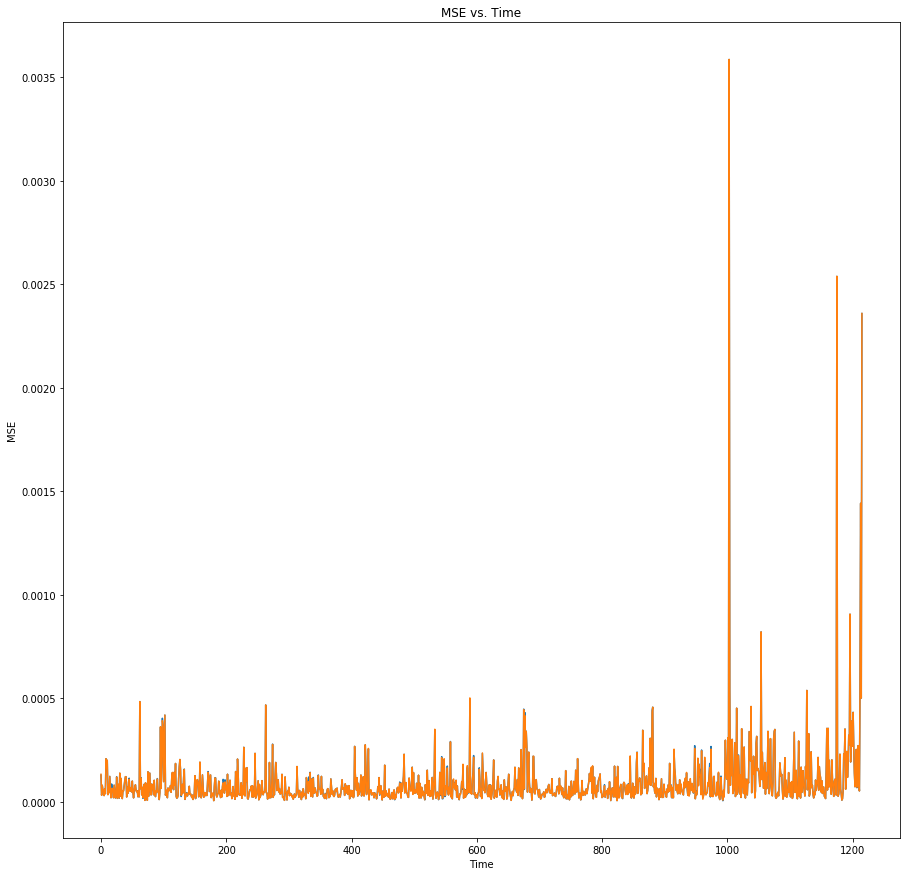

In [356]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(mse_lasso)), mse_lasso) #cum mse for lasso
plt.plot(range(len(mse_hist)), mse_hist) #cum mse for historical
plt.title('MSE vs. Time')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()

#### Differential

In [391]:
diff = []

for i in range(len(mse_hist)):
    diff.append(mse_hist[i]**(1/2) - mse_lasso[i]**(1/2))

cum_diff = np.cumsum(diff)
cum_diff = [cum_diff[i]/(i+1)**(1/2) for i in range(len(cum_diff))]

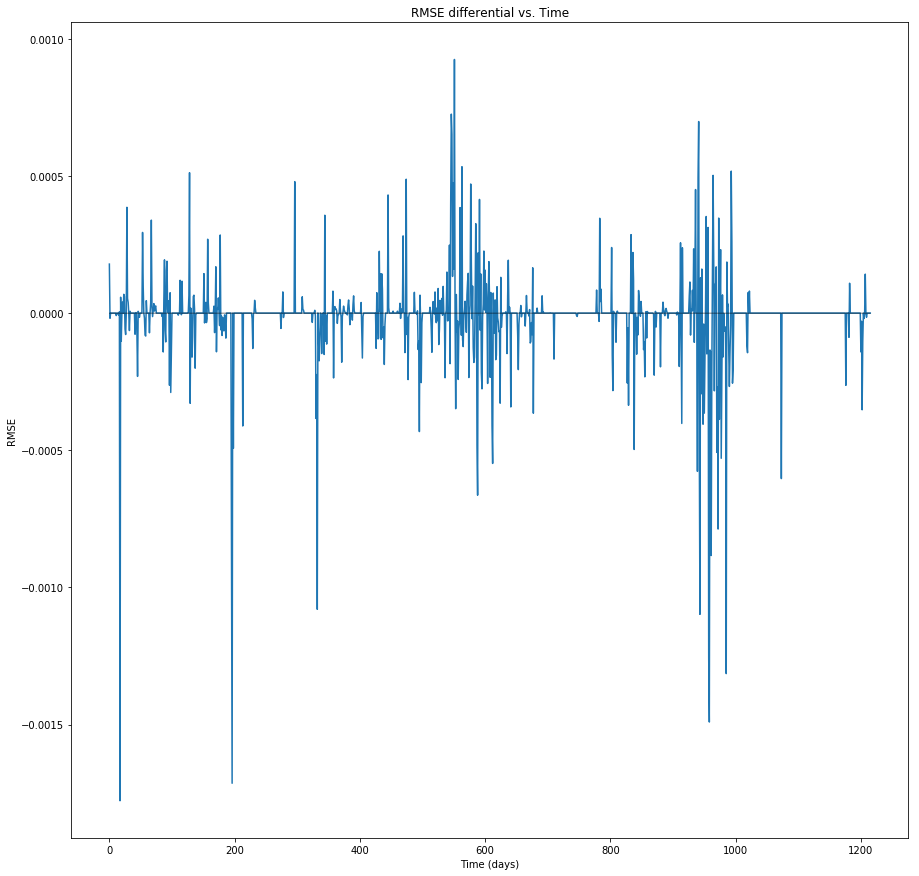

In [392]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(diff)), diff)
plt.plot(range(len(diff)), np.zeros(shape = len(diff)), 'k', linewidth=0.5)
plt.title('RMSE differential vs. Time')
plt.xlabel('Time (days)')
plt.ylabel('RMSE')
plt.show()

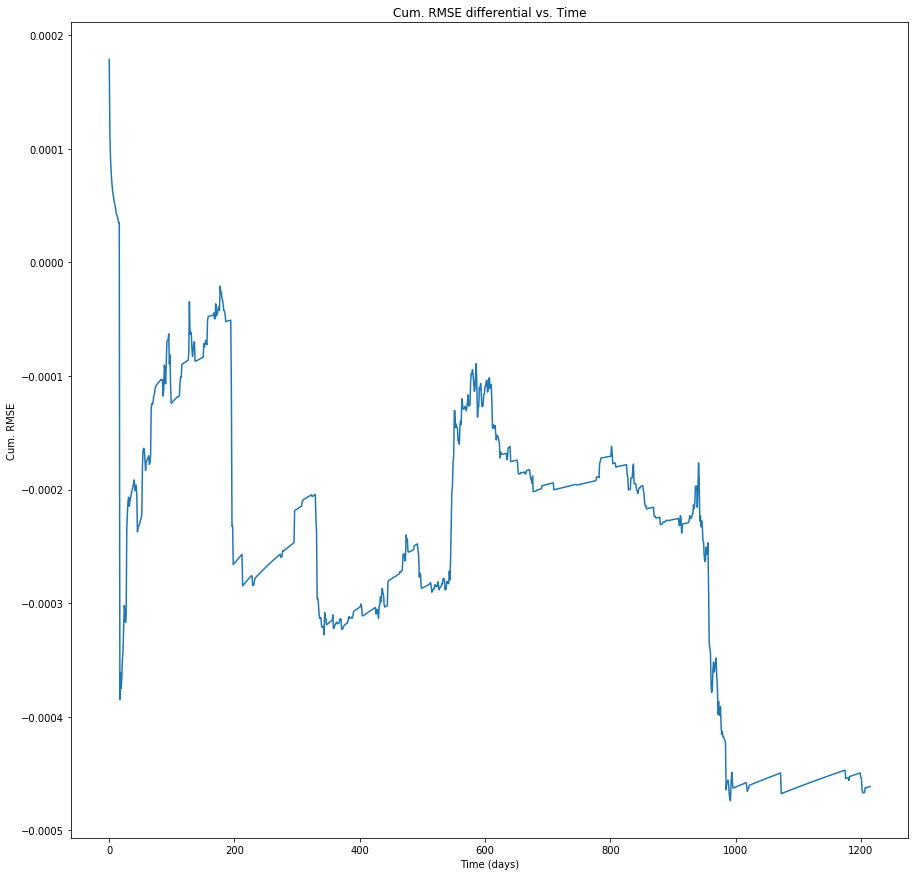

In [393]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(cum_diff)), cum_diff) 
plt.title('Cum. RMSE differential vs. Time')
plt.xlabel('Time (days)')
plt.ylabel('Cum. RMSE')
plt.show()

## Out-of-sample

#### Comparison

In [378]:
mse_lasso_test = []
mse_hist_test = []

mse_temp_lasso_test = 0
for key, value in cum_mse_lasso_test.items():
    mse_lasso_test.append(value)

mse_temp_hist_test = 0
for key, value in cum_mse_hist_test.items():
    mse_hist_test.append(value)
    

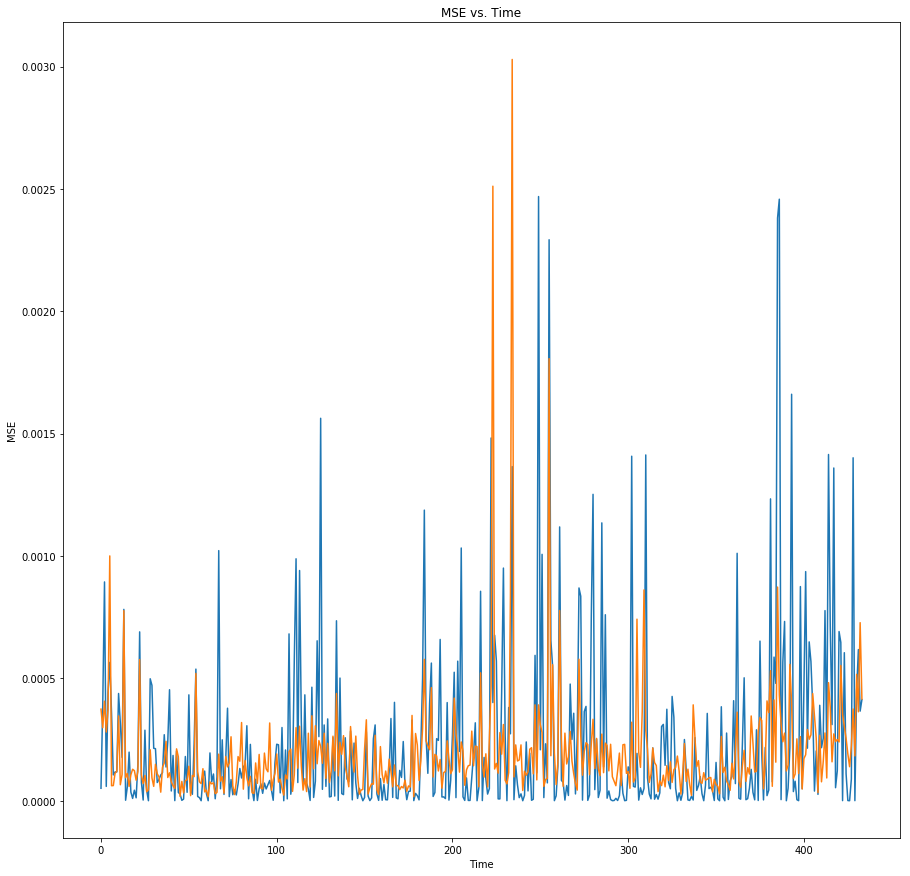

In [379]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(mse_lasso_test)), mse_lasso_test) #lasso --> get values
plt.plot(range(len(mse_hist_test)), mse_hist_test) #historical
plt.title('MSE vs. Time')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()

#### Differential

In [394]:
diff_test = []

for i in range(len(mse_hist_test)):
    diff_test.append(mse_hist_test[i]**(1/2) - mse_lasso_test[i]**(1/2))
    
cum_diff_test = np.cumsum(diff_test)
cum_diff_test = [cum_diff_test[i]/(i+1)**(1/2) for i in range(len(cum_diff_test))]

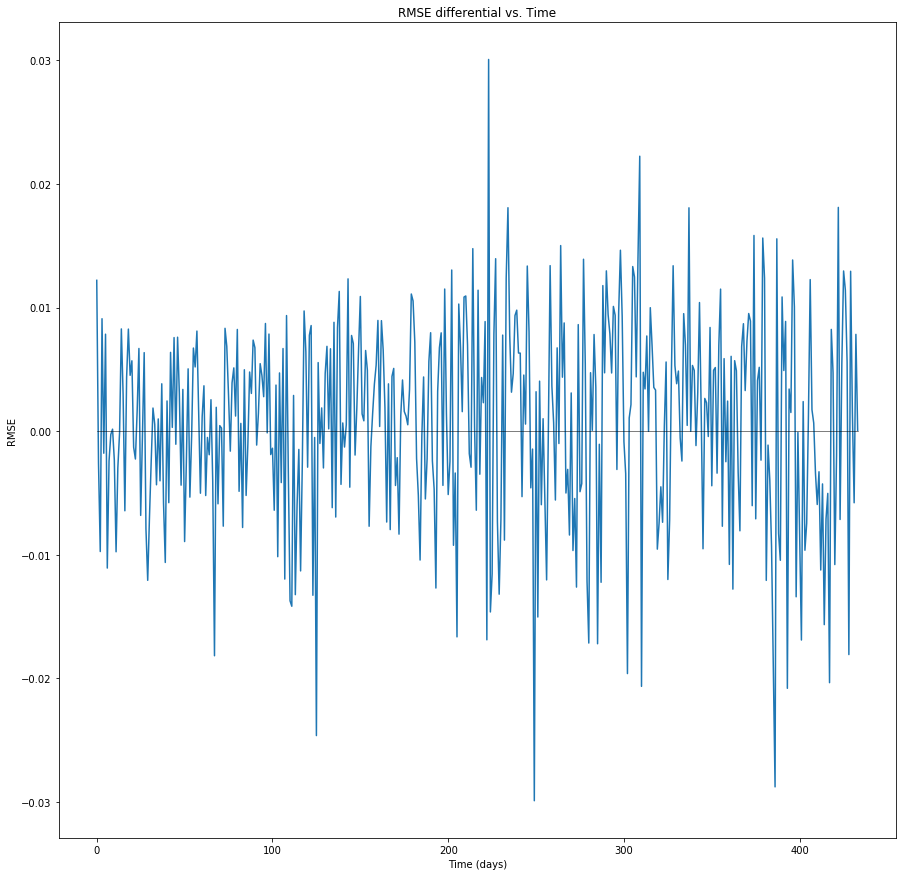

In [395]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(diff_test)), diff_test) 
plt.plot(range(len(diff_test)), np.zeros(shape = len(diff_test)), 'k', linewidth=0.5)
plt.title('RMSE differential vs. Time')
plt.xlabel('Time (days)')
plt.ylabel('RMSE')
plt.show()

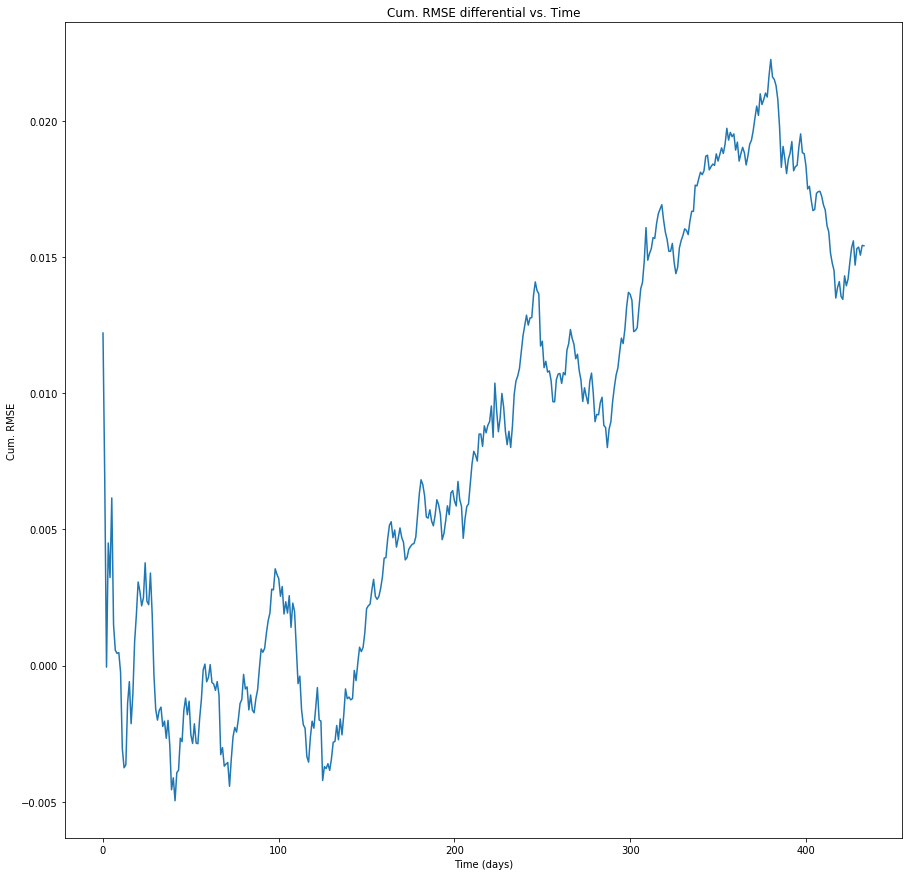

In [396]:
plt.subplots(figsize = (15,15))
plt.plot(range(len(cum_diff_test)), cum_diff_test) 
plt.title('Cum. RMSE differential vs. Time')
plt.xlabel('Time (days)')
plt.ylabel('Cum. RMSE')
plt.show()

# Plots for other models

Worse performance for the linear regression, as expected

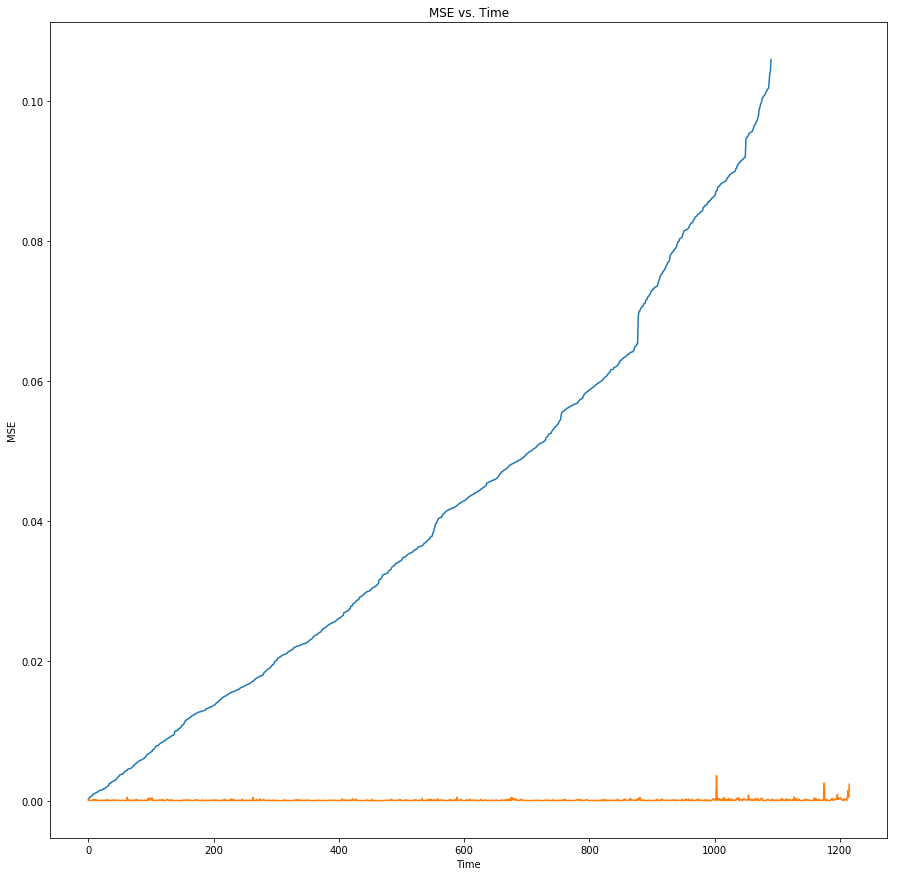

In [368]:
mse_lin = []

mse_temp_lin = 0
for key, value in cum_mse_lin.items():
    mse_lin.append(mse_temp_lin + value)
    mse_temp_lin = mse_temp_lin + value

plt.subplots(figsize = (15,15))
plt.plot(range(len(mse_lin)), mse_lin) #lasso --> get values
plt.plot(range(len(mse_hist)), mse_hist) #historical
plt.title('MSE vs. Time')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()